In [3]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display

import os

import keras
import keras.layers as layers
from keras import backend as K
import numpy as np

%matplotlib inline

Using TensorFlow backend.


TODO
* FFT variant with different bin sizes
* Debugging tools for comparing, listening to, and viewing clips
* Make evaluator that recreates a full clip
* Add audio quality comparisons between clean clips and cleaned clips for evaluation
* Check alignment between center of window and targets

* Change from tensor flow or investigate errors
* Confirm GPU use

* Evaluate different representations of complex numbers in terms of learnability

Notes
* On 'target to target' run, error of 0.09 was clearly understandable but some fuzz/static

In [4]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
fft = librosa.stft(wav)

In [12]:
# Constants and settings
WINDOW_SIZE = 11
FFT_BINS = 1025

In [13]:
#Utilities
def stack_fft(fft):
    return np.stack([fft.real, fft.imag], axis=-1)

def merge_fft_img(fft_img):
    return fft_img[:,:,0] + 1j * fft_img[:,:,1]

def unfold_target(t):
    return np.append(t.real, [t.imag])

def combine_target(t):
    return (t[0:FFT_BINS] + 1j * t[FFT_BINS:2*FFT_BINS]).reshape((1,FFT_BINS))

def targets_to_fft(targets):
    fft = np.empty((0,FFT_BINS))
    for i in range(0, targets.shape[0]):
        fft = np.concatenate([fft,combine_target(targets[i])])
    return fft.T  # swtich to (bins, samples) since model works in (samples, bins)
    

In [89]:
# Creating data from clip wave file
# output is (samples, window size, bins, layers), where image is depth 2 for real & imaginary
def clip_frames(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = librosa.stft(wav) # organized as bins, frames
    pad = np.zeros((FFT_BINS,frame_lead))
    fft = np.concatenate([pad, fft, pad], axis=-1)
    frames = np.empty(shape=(0,FFT_BINS,WINDOW_SIZE,2)) 
    for i in range(0, fft.shape[1] - WINDOW_SIZE + 1):
        frames = np.append(frames,[stack_fft(fft[:,i:i+WINDOW_SIZE])], axis=0)
    return frames

# output is array (samples, double bin length made up of real then imag)
def clip_targets(file):
    wav, rate = librosa.core.load(file)
    frame_lead = (WINDOW_SIZE-1)//2  # The amount before and after the target column
    fft = librosa.stft(wav)
    targets = np.empty(shape=(0,2*FFT_BINS))
    for i in range(0, fft.shape[1]):
        targets = np.append(targets, [unfold_target(fft[:,i:i+1].flatten())], axis=0)
    return targets

In [112]:
ft = clip_frames(test_file)
tt = clip_targets(test_file)

#Frame / target check
print(tt[0,1], tt[0,1026])
print( ft[0,1,5:6,0], ft[0,1,5:6,1])

# Round trip test
new_fft = targets_to_fft(tt)
new_wav = librosa.istft(new_fft)
Audio(new_wav,rate=22050)

-0.4412170350551605 -8.326672684688674e-17
[-0.44121704] [-8.32667268e-17]


In [94]:
# Iterate over clean & noisy folders to create frames and targets
def create_data(root, max_files = 50):
    clean_dir = root + "\\Clean\\"
    noisy_dir = root + "\\Noisy\\"
    frames = np.empty(shape=(0,FFT_BINS,WINDOW_SIZE,2))
    targets = np.empty(shape=(0,2*FFT_BINS))
    for file in os.listdir(clean_dir)[0:max_files]:
        filename = os.fsdecode(file)
        frames = np.concatenate((frames,clip_frames(noisy_dir + file)), axis=0)
        targets = np.concatenate((targets,clip_targets(clean_dir + file)), axis=0)
    return frames, targets


In [93]:
frames, targets = create_data("Assets\\DataShareArchive\\Test", 5)

In [102]:
# Real model (eventually)

inputs = layers.Input(shape=(FFT_BINS,WINDOW_SIZE,2)) # Full window
input_slice = layers.Input(shape=(FFT_BINS,1,2)) # Just the center row that we're trying to predict
conv1 = layers.Conv2D(16, kernel_size=3, activation='relu', padding='valid', 
                      input_shape=[FFT_BINS,WINDOW_SIZE,2])(inputs)
pool1 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)
conv2 = layers.Conv2D(16, kernel_size=3, activation='relu')(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2)
flat = layers.Flatten()(pool2)
dense0 = layers.Dense(1000, activation='relu')(flat)
dense1 = layers.Dense(750, activation='relu')(dense0)
dense2 = layers.Dense(750, activation='relu')(dense1)
flat_in = layers.Flatten()(input_slice)
merged = layers.concatenate([dense2, flat_in])
outputs = layers.Dense(2*FFT_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs,input_slice], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

In [107]:
model.fit([frames, frames[:,:,5:6,:]], targets, epochs=10, batch_size=32)

Epoch 1/10
992/992 [==============================] - 1s 1ms/step - loss: 1.5124
Epoch 2/10
992/992 [==============================] - 1s 1ms/step - loss: 1.2230
Epoch 3/10
992/992 [==============================] - 1s 1ms/step - loss: 1.0141
Epoch 4/10
992/992 [==============================] - 1s 1ms/step - loss: 0.8354
Epoch 5/10
992/992 [==============================] - 1s 1ms/step - loss: 0.7040
Epoch 6/10
992/992 [==============================] - 1s 1ms/step - loss: 0.5919
Epoch 7/10
992/992 [==============================] - 1s 1ms/step - loss: 0.5157
Epoch 8/10
992/992 [==============================] - 1s 1ms/step - loss: 0.4384
Epoch 9/10
992/992 [==============================] - 1s 1ms/step - loss: 0.3796
Epoch 10/10
992/992 [==============================] - 1s 1ms/step - loss: 0.3360


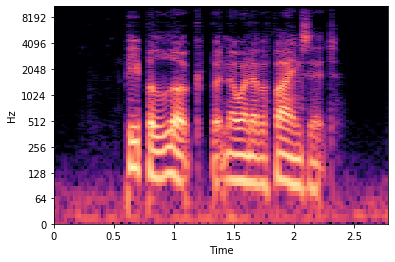

In [116]:
# Full round trip test

verify_file = "Assets\\DataShareArchive\\Test\\Noisy\\p232_010.wav"
verify_frames = clip_frames(verify_file)

output_targets = model.predict([verify_frames, verify_frames[:,:,5:6,:]])

p_fft = targets_to_fft(output_targets)

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

display_fft(p_fft)
p_wav = librosa.istft(p_fft)
Audio(p_wav,rate=22050)


Test & reference stuff 

(1025, 120)


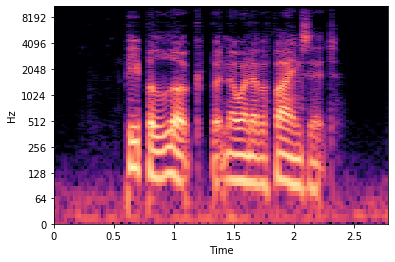

In [114]:
    
def show_fft(wav):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max), y_axis='log', x_axis='time')

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

print(new_fft.shape)

#show_fft(wav)
#show_fft(new_wav)
#Audio(wav, rate=22050)


In [13]:
# Test stuff for hacking around    
    
    a = np.array([[1+2j, 3+4j, 1.5+2.5j],[5+6j,7+8j, 5.5+6.5j]])
    print(a)
    a1 = a[0]
    print(a1)
    ar = a1.real
    ai = a1.imag
    t = np.append(ar, [ai])
    print (t)
    a2 = t[0:3] + 1j * t[3:6]
    print(a2)
    

[[1. +2.j  3. +4.j  1.5+2.5j]
 [5. +6.j  7. +8.j  5.5+6.5j]]
[1. +2.j  3. +4.j  1.5+2.5j]
[1.  3.  1.5 2.  4.  2.5]
[1. +2.j  3. +4.j  1.5+2.5j]


In [118]:
# ''do nothing' model that should be able to guess outputs from outputs

inputs = layers.Input(shape=(FFT_BINS*2,))
dense1 = layers.Dense(2000, activation='relu')(inputs)
dense2 = layers.Dense(2000, activation='relu')(dense1)
#flat = layers.Flatten()(dense)
#flat_in = layers.Flatten()(inputs)
#merged = layers.concatenate([flat, flat_in])
merged = layers.concatenate([dense2, inputs])
linear = layers.Dense(2000, activation='linear')(merged)
outputs = layers.Dense(2*FFT_BINS, activation='linear')(linear)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

model.fit(targets, targets, epochs=1, batch_size=32)

Epoch 1/1
7537/7537 [==============================] - 46s 6ms/step - loss: 0.5679
